In [3]:
# O módulo LocalOutlierFactor da biblioteca scikit-learn é usado para detectar outliers em um conjunto de dados
from sklearn.neighbors import LocalOutlierFactor
# O módulo KBinsDiscretizer da biblioteca scikit-learn é usado para discretizar 
# variáveis contínuas em bins (intervalos) de valores discretos
from sklearn.preprocessing import KBinsDiscretizer

#analise
from scipy.stats import shapiro

#data
import numpy as np
import pandas as pd

#visualização
import seaborn as sns

#aux
import os
import pickle
from IPython.display import clear_output

# essas duas linhas são usadas para definir como os números de ponto flutuante 
# serão formatados ao serem exibidos em numpy e pandas, garantindo que eles sejam 
# exibidos com uma precisão específica e sem notação científica.'''
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## carregar os dados

In [4]:
# load the dataframe object from the pickle file
with open(os.path.join('data', 'df_itens_geral_validos.pkl'), 'rb') as f:
    data = pickle.load(f)

In [5]:
data.shape #1922 itens

(1922, 32)

In [55]:
data.head()

,co_posicao,sg_area,co_item,tx_gabarito,co_habilidade,in_item_aban,tx_motivo_aban,nu_param_a,nu_param_b,nu_param_c,...,tp_lingua,in_item_adaptado,tp_versao_digital,texto_questao_tratado,wes,tf_idf,wes_own,classes_param_a_1,classes_param_b_1,classes_param_c_1
0,1,CH,71933,A,6.00000,0,NaN,2.23777,1.04258,0.29804,...,NaN,NaN,NaN,gráfico representar relação tamanho totalidade...,"[[0.0087, -0.015, 0.073, 0.0244, -0.0139, -0.0...","[0.15448001662671257, 0.19314334362072388, 0.1...","[[-0.2735036, -0.19421376, 0.26711008, 0.26224...",>2.092 e <=2.735,>0.652 e <=1.224,>0.203
1,2,CH,71990,B,19.00000,0,NaN,1.35599,1.23358,0.23895,...,NaN,NaN,NaN,apenas grande cidade apresentar império técnic...,"[[-0.0457, -0.009, 0.0753, -0.0198, -0.0479, -...","[0.14463912531808382, 0.1882090195082598, 0.11...","[[0.33006182, 0.08265074, 0.0863686, 0.1423417...",<=1.581,>1.224 e <=1.837,>0.203
2,3,CH,73431,A,17.00000,0,NaN,1.58426,1.26006,0.19016,...,NaN,NaN,NaN,maioria pessoa campo Vila Maria hoje exportado...,"[[-0.0246, -0.0379, 0.1021, 0.0378, -0.0864, -...","[0.08937166525923214, 0.12822456358498585, 0.1...","[[0.2161539, 0.16423477, -0.022779496, 0.32457...",>1.581 e <=2.092,>1.224 e <=1.837,>165 e <=0.203
3,4,CH,58249,B,26.00000,0,NaN,1.87124,-0.40493,0.17401,...,NaN,NaN,NaN,lixão mau tipo disposição final resíduo sólido...,"[[-0.0016, -0.0689, 0.0547, -0.0424, 0.0693, -...","[0.07309805460729854, 0.07309805460729854, 0.0...","[[-0.06490169, 0.25573078, 0.082524896, 0.1681...",>1.581 e <=2.092,<=0.652,>165 e <=0.203
4,5,CH,73854,D,27.00000,0,NaN,0.40830,1.46209,0.02447,...,NaN,NaN,NaN,esquema representar processo erosão encosta pr...,"[[-0.0128, -0.0053, 0.029, -0.052, -0.0304, -0...","[0.238915125308662, 0.2103826054875806, 0.2674...","[[-0.123734914, 0.036533087, 0.20261528, 0.195...",<=1.581,>1.224 e <=1.837,<=0.12487


## discretizar os parâmetros formando classes

- Discretização para agrupar valores contínuos em grupos distintos com o objetivo de simplificar a representação dos dados, torná-los mais fáceis de serem lidos e processados, além de tratar outliers ou problemas de escalonamento.

- Justificativa para a escolha do tipo de discretização:
    - como os parâmetros possuem uma característica de proporção, no sentido de que, por exemplo, para o parâmetro de discriminação "a" quanto maior o valor do parâmetro de discriminação, mais capaz o item será de identificar corretamente os indivíduos que possuem a habilidade e os que não a possuem, assim como os parâmetros de dificuldade e de acerto ao acaso, a melhor estratégia foi a com base em quartis. Também a divisão em quartis é balanceada, com o mesmo número de elementos em cada classe.

#### utilizando quartis

- **parametro a**

In [29]:
print(data["nu_param_a"].quantile(0.25))
print(data["nu_param_a"].quantile(0.50))
print(data["nu_param_a"].quantile(0.75))

1.5814750000000002
2.092105
2.734825


- Discretização por quartis, agrupa os valores contínuos em quatro classes com base nos quartis. Cada classe terá a mesma quantidade de de elementos, ou seja as classes estão balanceadas.

In [30]:
# definir os intervalos de discretização
intervalos = [data["nu_param_a"].min(), data["nu_param_a"].quantile(0.25), data["nu_param_a"].quantile(0.5), data["nu_param_a"].quantile(0.75), data["nu_param_a"].max()]
# criar uma nova coluna com as classes discretizadas
data["classes_param_a_1"] = pd.cut(data["nu_param_a"], intervalos, labels=['<=1.581', '>1.581 e <=2.092', '>2.092 e <=2.735', '>2.735'])

In [82]:
data.groupby('classes_param_a_1')['classes_param_a_1'].count()

classes_param_a_1
<=1.581             481
>1.581 e <=2.092    480
>2.092 e <=2.735    480
>2.735              481
Name: classes_param_a_1, dtype: int64

In [32]:
data.isnull().sum()

co_posicao                  0
sg_area                     0
co_item                     0
tx_gabarito                 0
co_habilidade              12
in_item_aban                0
tx_motivo_aban           1922
nu_param_a                  0
nu_param_b                  0
nu_param_c                  0
tx_cor                      0
co_prova                    0
id                          0
ano                         0
cor                         0
meio_aplicacao              0
num_questao                 0
area                      405
texto_questao               0
texto_base                266
alternativa_a             308
alternativa_b             114
alternativa_c             116
alternativa_d             112
alternativa_e              97
tp_lingua                1920
in_item_adaptado          722
tp_versao_digital        1517
texto_questao_tratado       0
wes                         0
tf_idf                      0
wes_own                     0
classes_param_a_1           1
classes_pa

In [33]:
data[data.classes_param_a_1.isna()]

,co_posicao,sg_area,co_item,tx_gabarito,co_habilidade,in_item_aban,tx_motivo_aban,nu_param_a,nu_param_b,nu_param_c,...,tp_lingua,in_item_adaptado,tp_versao_digital,texto_questao_tratado,wes,tf_idf,wes_own,classes_param_a_1,classes_param_b_1,classes_param_c_1
1272,114,CN,117868,E,25.00000,0,NaN,0.05808,8.96186,0.22071,...,NaN,0.00000,NaN,grupo pesquisa todo mundo vir buscar solução v...,"[[-0.022, 0.0315, 0.0752, -0.0268, 0.0625, -0....","[0.08895006210952702, 0.1322489084993874, 0.04...","[[-0.20457007, 0.2068289, -0.22812223, 0.41948...",NaN,>1.837,>0.203


In [34]:
data.loc[1272, 'classes_param_a_1'] = '<=1.581'

<AxesSubplot:xlabel='nu_param_a', ylabel='Density'>

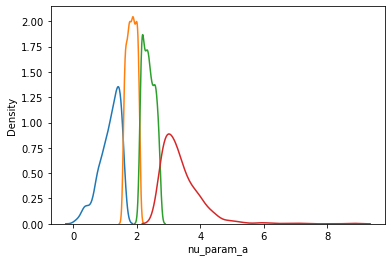

In [35]:
sns.kdeplot(data[data.classes_param_a_1 == '<=1.581']['nu_param_a'])
sns.kdeplot(data[data.classes_param_a_1 == '>1.581 e <=2.092']['nu_param_a'])
sns.kdeplot(data[data.classes_param_a_1 == '>2.092 e <=2.735']['nu_param_a'])
sns.kdeplot(data[data.classes_param_a_1 == '>2.735']['nu_param_a'])

- **parametro b**

In [36]:
print(data["nu_param_b"].quantile(0.25))
print(data["nu_param_b"].quantile(0.50))
print(data["nu_param_b"].quantile(0.75))

0.652025
1.224335
1.8368575


In [37]:
# definir os intervalos de discretização
intervalos = [data["nu_param_b"].min(), data["nu_param_b"].quantile(0.25), data["nu_param_b"].quantile(0.5), data["nu_param_b"].quantile(0.75), data["nu_param_b"].max()]
# criar uma nova coluna com as classes discretizadas
data["classes_param_b_1"] = pd.cut(data["nu_param_b"], intervalos, labels=['<=0.652', '>0.652 e <=1.224', '>1.224 e <=1.837', '>1.837'])

In [83]:
data.groupby('classes_param_b_1')['classes_param_b_1'].count()

classes_param_b_1
<=0.652             481
>0.652 e <=1.224    480
>1.224 e <=1.837    480
>1.837              481
Name: classes_param_b_1, dtype: int64

In [39]:
data.classes_param_b_1.isnull().sum()

1

In [40]:
data[data.classes_param_b_1.isna()]

,co_posicao,sg_area,co_item,tx_gabarito,co_habilidade,in_item_aban,tx_motivo_aban,nu_param_a,nu_param_b,nu_param_c,...,tp_lingua,in_item_adaptado,tp_versao_digital,texto_questao_tratado,wes,tf_idf,wes_own,classes_param_a_1,classes_param_b_1,classes_param_c_1
32,37,CH,58919,A,21.00000,0,NaN,0.98999,-1.26778,0.23087,...,NaN,NaN,NaN,meio comunicação funcionar elo diferente segme...,"[[0.0368, -0.0385, 0.0528, 0.0069, -0.0587, -0...","[0.1485992889868012, 0.2533665614268401, 0.121...","[[-0.1763143, 0.40396994, 0.013750436, -0.4270...",<=1.581,NaN,>0.203


In [41]:
data.loc[32, 'classes_param_b_1'] = '<=0.652'

<AxesSubplot:xlabel='nu_param_b', ylabel='Density'>

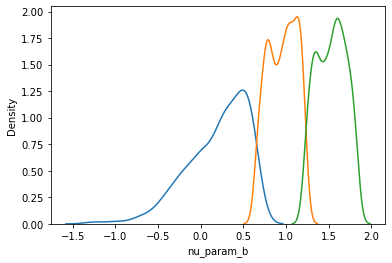

In [42]:
sns.kdeplot(data[data.classes_param_b_1 == '<=0.652']['nu_param_b'])
sns.kdeplot(data[data.classes_param_b_1 == '>0.652 e <=1.224']['nu_param_b'])
sns.kdeplot(data[data.classes_param_b_1 == '>1.224 e <=1.837']['nu_param_b'])
sns.kdeplot(data[data.classes_param_b_1 == '>1.837 ']['nu_param_b'])

- **parametro c**

In [43]:
print(data["nu_param_c"].quantile(0.25))
print(data["nu_param_c"].quantile(0.50))
print(data["nu_param_c"].quantile(0.75))

0.12487
0.165
0.2031625


In [57]:
# definir os intervalos de discretização
intervalos = [data["nu_param_c"].min(), data["nu_param_c"].quantile(0.25), data["nu_param_c"].quantile(0.5), data["nu_param_c"].quantile(0.75), data["nu_param_c"].max()]
# criar uma nova coluna com as classes discretizadas
data["classes_param_c_1"] = pd.cut(data["nu_param_c"], intervalos, labels=['<=0.12487', '>0.12487 e <=0.165', '>0.165 e <=0.203', '>0.203'])

In [84]:
data.groupby('classes_param_c_1')['classes_param_c_1'].count()

classes_param_c_1
<=0.12487             482
>0.12487 e <=0.165    480
>0.165 e <=0.203      479
>0.203                481
Name: classes_param_c_1, dtype: int64

In [63]:
data.isnull().sum()

co_posicao                  0
sg_area                     0
co_item                     0
tx_gabarito                 0
co_habilidade              12
in_item_aban                0
tx_motivo_aban           1922
nu_param_a                  0
nu_param_b                  0
nu_param_c                  0
tx_cor                      0
co_prova                    0
id                          0
ano                         0
cor                         0
meio_aplicacao              0
num_questao                 0
area                      405
texto_questao               0
texto_base                266
alternativa_a             308
alternativa_b             114
alternativa_c             116
alternativa_d             112
alternativa_e              97
tp_lingua                1920
in_item_adaptado          722
tp_versao_digital        1517
texto_questao_tratado       0
wes                         0
tf_idf                      0
wes_own                     0
classes_param_a_1           0
classes_pa

In [60]:
data[data.classes_param_c_1.isna()]

,co_posicao,sg_area,co_item,tx_gabarito,co_habilidade,in_item_aban,tx_motivo_aban,nu_param_a,nu_param_b,nu_param_c,...,tp_lingua,in_item_adaptado,tp_versao_digital,texto_questao_tratado,wes,tf_idf,wes_own,classes_param_a_1,classes_param_b_1,classes_param_c_1
1148,51,CH,118125,E,21.00000,0,NaN,1.14176,0.61713,0.00161,...,NaN,0.00000,NaN,nenhum outro época corpo magro adquirir sentid...,"[[-0.042, -0.044, 0.0544, 0.0243, -0.0372, -0....","[0.06440539172358772, 0.02406724874754997, 0.0...","[[-0.21183322, 0.2763258, -0.28025597, 0.26888...",<=1.581,<=0.652,NaN


In [61]:
data.loc[1148, 'classes_param_c_1'] = '<=0.12487'

<AxesSubplot:xlabel='nu_param_c', ylabel='Density'>

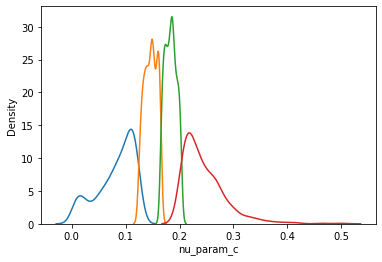

In [66]:
sns.kdeplot(data[data.classes_param_c_1 == '<=0.12487']['nu_param_c'])
sns.kdeplot(data[data.classes_param_c_1 == '>0.12487 e <=0.165']['nu_param_c'])
sns.kdeplot(data[data.classes_param_c_1 == '>0.165 e <=0.203']['nu_param_c'])
sns.kdeplot(data[data.classes_param_c_1 == '>0.203']['nu_param_c'])

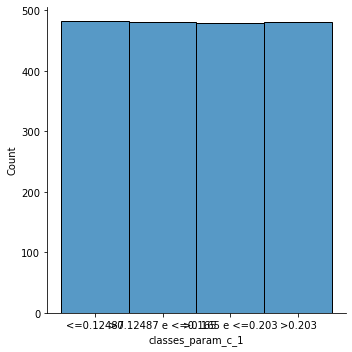

In [64]:
sns.displot(data.classes_param_c_1)

In [65]:
# salvar o objeto dataframe em um arquivo .pkl
file = os.path.join('data', 'df_itens_geral_validos.pkl')
with open(file, 'wb') as f:
    pickle.dump(data, f)